The MIT License (MIT)

Copyright (c) 2019 Edward Barton

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [42]:
# [380, 730] nm, 10 nm increments, 36 total measurements
a_spd = np.diag(np.genfromtxt('a_spd.csv', delimiter=',')) # 36 x 1 Standard Light A Spectral Power Distribution
d65_spd = np.diag(np.genfromtxt('d65_spd.csv', delimiter=',')) # 36 x 1 D65 Spectral Power Distribution
cmfs = np.genfromtxt('cmfs.csv', delimiter=',') # 36 x 3 CIE XYZ 2º Obs Color Matching Functions
cam_qe = np.genfromtxt('cam_qe.csv', delimiter=',') # 36 x 3 TODO: LOAD YOUR OWN CAMERA SPECTRAL SENSITIVITIES
colorchecker = np.genfromtxt('colorchecker.csv', delimiter=',').T # 36 x 140 ColorChecker Digital SG
srgb2xyz = np.genfromtxt('srgb.csv', delimiter=',') # 3 x 3 sRGB to XYZ color matrix

In [43]:
# some color related helper functions

def planckian_locus(cct):
    cct2 = cct * cct
    u = 0.860117757 + 1.54118254e-4 * cct + 1.28641212e-7 * cct2
    u /= 1 + 8.42420235e-4 * cct + 7.08145163e-7 * cct2
    
    v = 0.317398726 + 4.22806245e-5 * cct + 4.20481691e-8 * cct2
    v /= 1 - 2.89741816e-5 * cct + 1.61456053e-7 * cct2
    
    return u, v

def get_xyz(cct, duv):
    u, v = planckian_locus(cct)
    
    if duv != 0:
        u1, v1 = planckian_locus(cct + 0.01)

        du = u - u1
        dv = v - v1

        u = u - duv * (dv / np.sqrt(du ** 2 + dv ** 2))
        v = v + duv * (du / np.sqrt(du ** 2 + dv ** 2))
    
    x = 3 * u / (2 * u - 8 * v + 4)
    y = 2 * v / (2 * u - 8 * v + 4)
    
    return np.array([[x / y], [1], [(1 - x - y)/y]])

def get_wb_mat(m1, m2, cct, duv):
    q = np.clip((1./cct - 1./2856)/(1./6504 - 1./2856), 0, 1)
    xyz2cam = m1 * (1 - q) + m2 * q
    xyz2cam /= sum(xyz2cam[1])
    
    wb = xyz2cam@get_xyz(cct, duv)
    wb /= sum(wb[1])
    wb = np.linalg.inv(np.diagflat(wb))
    
    srgb2cam = xyz2cam@srgb2xyz
    srgb2cam /= np.sum(srgb2cam, axis=1)[:, np.newaxis]
    return wb, np.linalg.inv(srgb2cam)

def view_images(filename, wb, cam2srgb):
    # TODO: image should be demosaiced already and un-white-balanced
    in_lin = np.clip(2 * np.divide(imageio.imread(filename, pilmode='RGB'), 255.), 0, 1)
    
    in_gamma = np.clip(np.power(in_lin, 1/2.2), 0, 1)
    
    wb_lin = np.clip(in_lin@wb, 0, 1)
    wb_gamma = np.clip(np.power(wb_lin, 1/2.2), 0, 1)
    
    srgb_lin = np.clip(wb_lin@cam2srgb.T, 0, 1)
    srgb = np.clip(np.power(srgb_lin, 1/2.2), 0, 1)
    
    plt.figure()
    plt.title('Linear Raw')
    plt.imshow(in_lin)
    plt.figure()
    plt.title('Gamma Corrected Raw')
    plt.imshow(in_gamma)
    plt.figure()
    plt.title('White Balanced')
    plt.imshow(wb_gamma)
    plt.figure()
    plt.title('White Balanced sRGB')
    plt.imshow(srgb)

[[ 2.48732615 -1.14790286 -0.06438987]
 [-0.05729699  0.99411801  0.06317898]
 [-0.01737198  0.21002673  0.40272377]]
[[ 1.0864497  -0.37908128 -0.0861656 ]
 [-0.36443884  1.12924464  0.2351942 ]
 [-0.13958     0.33982942  0.82358651]]
5.1285603439364005
1.8464316756055408


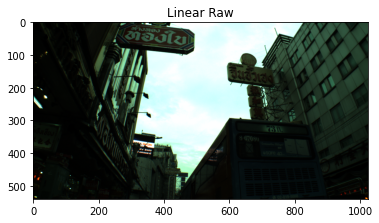

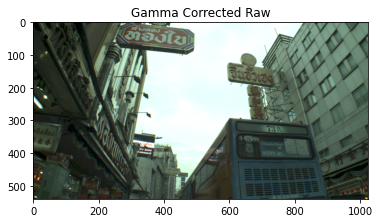

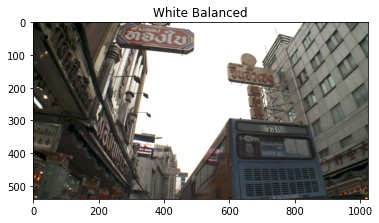

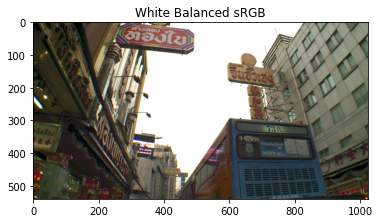

In [44]:
# set source spectral responses
X1 = a_spd@cam_qe   # camera response under std lght A illuminant
X2 = d65_spd@cam_qe # camera response under D65 illuminant

# set target response, using D65 since we target D65 display
Y  = d65_spd@cmfs

# perform moore-penrose for least-squares solve
W1 = (np.linalg.pinv(X1)@Y).T
W2 = (np.linalg.pinv(X2)@Y).T

# invert to find XYZ to camera space
iW1 = np.linalg.inv(W1)
iW2 = np.linalg.inv(W2)

# normalize to keep green/luma energy
iW1 /= sum(iW1[1])
iW2 /= sum(iW2[1])

print(iW1)
print(iW2)

# actually use cct/duv to find ccm and correct image
wb, cam2srgb = get_wb_mat(iW1, iW2, 5500, 0.015)

# L2 error of our estimation
print(np.linalg.norm(cmfs.T - W1@cam_qe.T))
print(np.linalg.norm(cmfs.T - W2@cam_qe.T))

view_images('image.png', wb, cam2srgb)
